In [32]:
import openturns as ot
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from math import factorial

from shapley import SobolIndices
from shapley.tests import ProductGaussian, AdditiveGaussian
from shapley.plots import set_style_paper, plot_error, plot_cover
from shapley.tests.utils import true_gaussian_full_ind_sobol

%load_ext autoreload
%autoreload 2

%matplotlib inline

set_style_paper()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [38]:
dim = 3
corr = 0.5

beta = None
Model = AdditiveGaussian

model = Model(dim=dim, beta=beta)
theta = [0., 0., corr]
model.copula_parameters = theta
true_indices = {}
true_indices['full'], true_indices['ind'] = true_gaussian_full_ind_sobol(theta, dim=dim)

true_results = {}
for indice_type in ['full', 'ind']:
    true_results[indice_type] = {
        'First Sobol': true_indices[indice_type],
        'Total Sobol': true_indices[indice_type]
    }

In [60]:
n_boot = 1000
n_run = 500

name_ticks = 'n'
n_n_ticks = 30
min_n_ticks = 10
max_n_ticks = 100

all_n_ticks = np.logspace(np.log10(min_n_ticks), np.log10(max_n_ticks), n_n_ticks, base=10, dtype=int)
all_n_ticks = np.unique(all_n_ticks)
n_n_ticks = len(all_n_ticks)

In [61]:
%%time
all_first_results = {}
all_total_results = {}
for indice_type in ['full', 'ind']:
    all_first_results[indice_type] = np.zeros((n_n_ticks, n_run, dim, n_boot))
    all_total_results[indice_type] = np.zeros((n_n_ticks, n_run, dim, n_boot))

estimator = 'sobolmara'
for i_ticks, n_ticks in enumerate(all_n_ticks):
    print('n_ticks:', n_ticks)
    n_sample = int((n_ticks * (dim - 1) + n_var) / (4*dim))
    n_sample = int(n_ticks)
    print('n_sample:', n_sample)
    for i_run in range(n_run):            
        sobol = SobolIndices(model.input_distribution)
        sobol.build_uncorr_sample(model=model, n_sample=n_sample)
        for indice_type in ['full', 'ind']:
            sobol_results = sobol.compute_indices(n_boot=n_boot, estimator=estimator, indice_type=indice_type)
            all_first_results[indice_type][i_ticks, i_run] = sobol_results.full_first_indices
            all_total_results[indice_type][i_ticks, i_run] = sobol_results.full_total_indices

n_ticks: 10
n_sample: 10
n_ticks: 11
n_sample: 11
n_ticks: 12
n_sample: 12
n_ticks: 13
n_sample: 13
n_ticks: 14
n_sample: 14
n_ticks: 16
n_sample: 16
n_ticks: 17
n_sample: 17
n_ticks: 18
n_sample: 18
n_ticks: 20
n_sample: 20
n_ticks: 22
n_sample: 22
n_ticks: 23
n_sample: 23
n_ticks: 25
n_sample: 25
n_ticks: 28
n_sample: 28
n_ticks: 30
n_sample: 30
n_ticks: 32
n_sample: 32
n_ticks: 35
n_sample: 35
n_ticks: 38
n_sample: 38
n_ticks: 41
n_sample: 41
n_ticks: 45
n_sample: 45
n_ticks: 48
n_sample: 48
n_ticks: 52
n_sample: 52
n_ticks: 57
n_sample: 57
n_ticks: 62
n_sample: 62
n_ticks: 67
n_sample: 67
n_ticks: 72
n_sample: 72
n_ticks: 78
n_sample: 78
n_ticks: 85
n_sample: 85
n_ticks: 92
n_sample: 92
n_ticks: 100
n_sample: 100
Wall time: 3min 18s


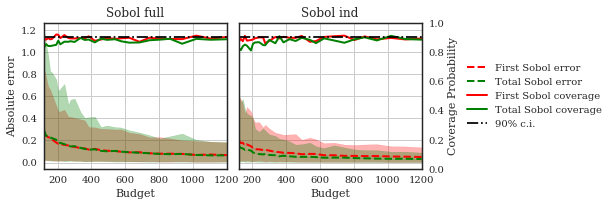

In [64]:
# Coverage probability
ci_prob = 0.10
error_type = 'absolute'
logscale = False
ci_method = 'bootstrap'
do_cover = True
savefigs = True

x_ticks = all_n_ticks * dim * 4
x_axes = ['full', 'ind']
name_axes = x_axes
x_label = 'Budget'

n_col = 2
fig, axes = plt.subplots(1, n_col, figsize=(3.3*n_col, 3.), sharex=True, sharey=True) 
    
axes = [axes] if n_col == 1 else axes

for i_ax, (indice_type, ax_err) in enumerate(zip(x_axes, axes)):
    # Chose the associated result
    results = {
        'First Sobol': all_first_results[indice_type],
        'Total Sobol': all_total_results[indice_type]
    }

    plot_error(results, true_results[indice_type], x_ticks, ax=ax_err, error_type=error_type, logscale=logscale)

    ax_cov = ax_err.twinx()
    ax_cov.set_ylim(0., 1.)
    if do_cover:
        plot_cover(results, true_results[indice_type], x_ticks, ax=ax_cov, ci_prob=ci_prob,
                  ci_method=ci_method)
        if i_ax < n_col - 1:
            plt.setp(ax_cov.get_yticklabels(), visible=False)
            ax_cov.set_ylabel('')
            ax_cov.set_yticks([])

    if i_ax > 0:
        plt.setp(ax_err.get_yticklabels(), visible=False)
        ax_err.set_ylabel('')

    ax_err.set_xlabel('%s' % (x_label))
    ax_err.grid()
    ax_err.set_title('Sobol %s' % (indice_type))

    if i_ax == n_col-1:
        h_err, l_err = ax_err.get_legend_handles_labels()
        h_cov, l_cov = ax_cov.get_legend_handles_labels()
        ax_err.legend(h_err + h_cov, l_err + l_cov, loc='center left', 
                          bbox_to_anchor=(1.2, 0.5))

fig.tight_layout(pad=1.0)
if savefigs:
    figname = './output/%s_precision_dim_%d_full_ind_corr_%.2f' % (Model.__name__, dim, corr)
    figname += 'ciprob_%.2f_error_%s_%s' % (ci_prob, error_type, ci_method)
    fig.savefig(figname + '.pdf', bbox_inches='tight')
    fig.savefig(figname + '.png', bbox_inches='tight')